# IBM Data Science Specialization Capstone Project - Neighbourhood Wars

This Jupyter Notebook is used to prepare capstone project for IBM Professional Data Science Certificate on Coursera.com. The aim of this project is to find and visualize similar neighbourhoods in different cities (Budapest, London, New York, Toronto) You find the full report on https://github.com/dedi400/Coursera_Capstone

In [1]:
import math
import numpy as np
import pandas as pd
import foursquare
import googlemaps
from tqdm.notebook import tqdm
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
import seaborn as sns
import colorsys
import folium

%matplotlib inline

As an input I'm using geocoded neighbourhood data from previous sessions. You can find how London geocoding was done here: https://github.com/dedi400/Coursera_Capstone/blob/main/London_geocoding.ipynb. The other cities are created in a very similar way.

In [2]:
#input data paths:
cities_path={'Budapest':'data/bp_w_geocode.csv',
             'London':'data/london_w_geocode.csv',
             'Toronto':'data/toronto_w_geocode.csv',
             'New York':'data/new_york_w_geocode.csv'}

## Foursquare requests

Similarities are calculated based on the similar facilities one can find in two neighbourhoods. For this I'll use Foursquare and Google Places APIs to find the data. I'm starting with Foursquare.

In [3]:
#IDs to be deleted before uploading to Git!
fq_client = foursquare.Foursquare(client_id='xxx',
                               client_secret='xxx')

To simplify the code I have created two functions. The first one, `get_nearby_venues` is almost same as we used in the practice lab for New York neighborhood clustering.

The second one, `fq_onehot_grouped` automates data request and cleaning with the following steps for every neighbourhoods:
1. requests Foursquare data (using `get_nearby_venues`)
2. creates a one-hot encoded table from the received venues list
3. converts it into a frequency table

I also put some checking outputs, so I can tell if something went wrong.

These are the same data conversion steps we did in New York clustering lab.

In [4]:
def get_nearby_venues(client, names, latitudes, longitudes, radius=500, limit=100):
    '''Collecting recommended venues from multiple locations using Foursquare API.
    names, latitudes and longitudes are iterable objects (e.g. lists or series) of the same size.
    Returning DataFrame with all venues name, location and category'''
    
    venues_list=[]
    for name, lat, lng in tqdm(zip(names, latitudes, longitudes),desc='foursquare request',total=len(names)):
        results=client.venues.explore(params={'ll':str(lat)+','+str(lng),'radius':radius,'limit':limit})
        results=results['groups'][0]['items']
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [5]:
def fq_onehot_grouped(df_city,fq_client,city_name='',radius=500,limit=100):
    '''Expects a dataframe with at least "Neighbourhood","Lat" and "Lon"
    columns, collects nearby venues around the coordinates using the get_nearby_venues() function
    and converts it into a one-hot coded, aggregated (using the sum() function) dataframe.'''
    
    print('Processing neighbourhood data of ',city_name)
    
    #Foursquare request
    df_venues=get_nearby_venues(fq_client,df_city['Neighbourhood'],df_city['Lat'],df_city['Lon'],
                                radius=radius,limit=limit) #,silent=True
    print('Venues found: ',df_venues.shape[0])
    print('Unique categories: ',len(df_venues['Venue Category'].unique()))
    
    #histogram to check if enough results were returned
    venue_count=df_venues.groupby('Neighbourhood').count().sort_values(by='Venue',ascending=False)
    ax=venue_count['Venue'].plot(kind="hist",figsize=(7,7),bins=20)
    ax.set_xlabel('No. of recommended venues in '+city_name)
    
    #one-hot encoding venues
    city_onehot =pd.get_dummies(df_venues[['Venue Category']], prefix="", prefix_sep="")
    city_onehot['Neighbourhood'] = df_venues['Neighbourhood'] 

    print('One-hot coding venues done, ',city_onehot.shape[1],' total columns')
    
    #using groupby with the function provided
    return df_city.merge(city_onehot.groupby('Neighbourhood').sum().reset_index())

With these functions I could create a frequency list of any number of cities with a single `for` loop. I will not do it for the sake of readability though. So you can find the conversion for each selected cities below:

### Budapest

Processing neighbourhood data of  Budapest



Venues found:  8413
Unique categories:  361
One-hot coding venues done,  362  total columns


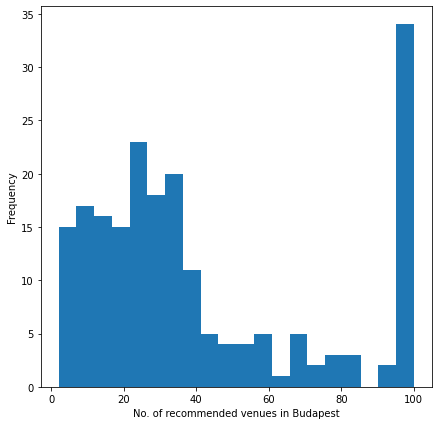

In [6]:
df_bp=pd.read_csv(cities_path['Budapest'],index_col=0)
df_bp_freq=fq_onehot_grouped(df_bp,fq_client,city_name='Budapest',radius=1000)
             

In [7]:
df_bp_freq.head()

,Neighbourhood,ADMIN_LEVE,geometry,Lon,Lat,ATM,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,...,Vietnamese Restaurant,Volleyball Court,Water Park,Waterfront,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Spanyolrét,10,POINT (18.9816269404147 47.46681118057516),18.981627,47.466811,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Pösingermajor,10,POINT (18.97902691669148 47.47534846098959),18.979027,47.475348,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Csillebérc,10,POINT (18.96447587425794 47.48778022616992),18.964476,47.487780,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Széchenyihegy,10,POINT (18.98177263365786 47.49180290940061),18.981773,47.491803,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Svábhegy,10,POINT (18.97799832242943 47.50112631221246),18.977998,47.501126,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### London

Processing neighbourhood data of  London



Venues found:  19313
Unique categories:  429
One-hot coding venues done,  430  total columns


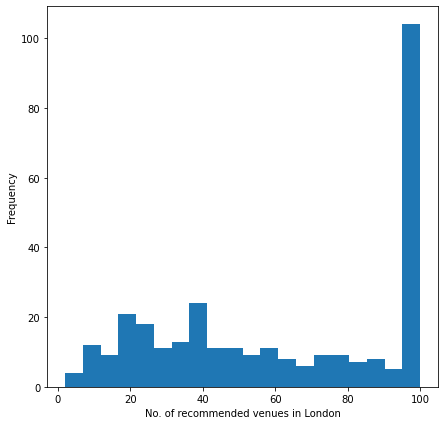

In [8]:
df_london=pd.read_csv(cities_path['London'],index_col=0)
df_london_freq=fq_onehot_grouped(df_london,fq_client,city_name='London',radius=1000)

In [9]:
df_london_freq.head()

,Neighbourhood,Borough,Postcode,Lat,Lon,ATM,Accessories Store,Acupuncturist,Adult Boutique,Afghan Restaurant,...,Windmill,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio,Zoo,Zoo Exhibit
0,Abbey Wood,"Bexley, Greenwich",SE2,51.492612,0.118818,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Acton,"Ealing, Hammersmith and Fulham","W3, W4",51.508372,-0.274440,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,Aldgate,City,EC3,51.513438,-0.077171,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Aldwych,Westminster,WC2,51.513266,-0.117183,0,0,0,0,0,...,0,2,1,0,0,1,0,0,0,0
4,Anerley,Bromley,SE20,51.411911,-0.067978,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Toronto

Processing neighbourhood data of  Toronto



Venues found:  4907
Unique categories:  338
One-hot coding venues done,  339  total columns


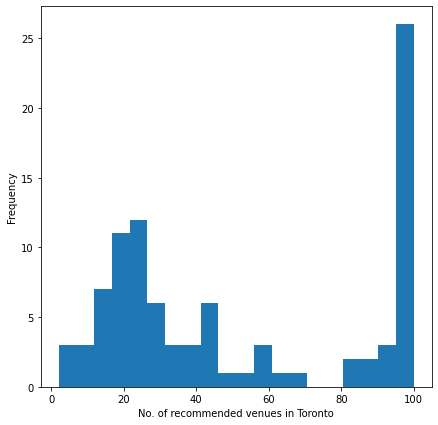

In [10]:
df_toronto=pd.read_csv(cities_path['Toronto'],index_col=0)
df_toronto_freq=fq_onehot_grouped(df_toronto,fq_client,city_name='Toronto',radius=1000)

In [11]:
df_toronto_freq.head()

,Borough,Neighbourhood,Lat,Lon,Accessories Store,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Animal Shelter,...,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,North York,Parkwoods,43.756123,-79.329636,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,North York,Victoria Village,43.726780,-79.310738,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Downtown Toronto,"Regent Park, Harbourfront",43.655354,-79.365044,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
3,North York,"Lawrence Manor, Lawrence Heights",43.721996,-79.445915,0,0,0,0,2,0,...,0,0,0,0,0,0,0,0,2,0
4,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.663910,-79.388733,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,2


### New York

Processing neighbourhood data of  New York



Venues found:  20486
Unique categories:  471
One-hot coding venues done,  472  total columns


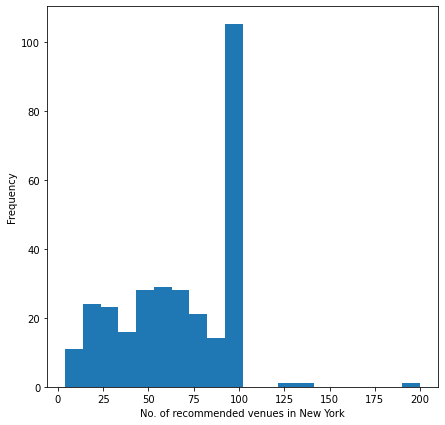

In [12]:
df_newyork=pd.read_csv(cities_path['New York'],index_col=0)
df_newyork_freq=fq_onehot_grouped(df_newyork,fq_client,city_name='New York',radius=1000)

In [13]:
df_newyork_freq.head()

,Borough,Neighbourhood,Lat,Lon,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Lounge,Airport Service,...,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Bronx,Wakefield,40.894705,-73.847201,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Bronx,Co-op City,40.874294,-73.829939,2,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,Bronx,Eastchester,40.887556,-73.827806,0,0,0,0,0,0,...,0,0,0,1,0,1,1,0,0,0
3,Bronx,Fieldston,40.895437,-73.905643,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,Bronx,Riverdale,40.890834,-73.912585,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


## Google Places
My aim was to make this analysis "family friendly" so I want to priorize facilities that are more important for families with children. The problem is, that Foursquare returns the 100 most popular facilities within a radius, and sometimes important facilities (e.g. schools) are not in the list, or not all of them are listed. I'll search for these specific facilities and adjust the frequency tables with some additional colums.

I have selected the following facilities to have priority:
- schools
- playgrounds
- medical centers and health care facilities
- pharmacies

I am going to use Google Places for this task, I found it more easy to search for specific topics here. The disatvantage of this method I couldn't overcome yet, that Google returns 20 results maximum.

In [14]:
keywords=['playground','school','health','medical','pharmacy']
google=googlemaps.Client(key='xxx') #key to be deleted before publishing!

Again, I'm defining a function that makes the request to Google API so I can use it for each city. Function is created in a way that it can be used for Pandas `apply()` function.

In [15]:
def google_places_count(row,client,keyword,radius=1000):
    coord={'lat':row['Lat'],'lng':row['Lon']}
    results=client.places_nearby(keyword=keyword,location=coord,radius=radius)
    return len(results['results'])

### Budapest
Please note that `progress_apply()` function is the same as `apply()` but it adds a progress bar. It's done with [tqdm library](https://tqdm.github.io/).

In [73]:
for k in tqdm(keywords):
    tqdm.pandas(desc=k,leave=False)
    df_bp_freq['gl_'+k]=df_bp_freq.progress_apply(google_places_count,args=(google,k),axis=1)
    
df_bp_freq.head()

,Neighbourhood,Lon,Lat,ATM,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,...,Wine Shop,Women's Store,Yoga Studio,Zoo,Zoo Exhibit,gl_playground,gl_school,gl_health,gl_pharmacy,gl_medical
0,Spanyolrét,18.981627,47.466811,0,0,0,0,0,0,0,...,0,0,0,0,0,16,14,4,3,3
1,Pösingermajor,18.979027,47.475348,0,0,0,0,0,0,0,...,0,0,0,0,0,7,3,3,1,2
2,Csillebérc,18.964476,47.487780,0,0,0,0,0,0,0,...,0,0,0,0,0,2,5,1,0,0
3,Széchenyihegy,18.981773,47.491803,0,0,0,0,0,0,0,...,0,0,0,0,0,10,8,2,3,1
4,Svábhegy,18.977998,47.501126,0,0,0,0,0,0,0,...,0,0,0,0,0,9,15,3,1,1


And a bit of data cleaning. Some earlier runs revealed that Google searches are so overrepresented in this way that these features need to be normalized. I made it very simple, I divided them by 10. Then I'm dropping any unneccessary columns. Also, I want only one column for health care facilities so I'm aggregating them (and keeping the normalization):

In [75]:
for k in keywords:
    df_bp_freq['gl_'+k]/=10
df_bp_freq.drop(['ADMIN_LEVE','geometry'],axis=1,inplace=True)
df_bp_freq['gl_health']=(df_bp_freq['gl_health']+df_bp_freq['gl_medical'])/2
df_bp_freq.drop('gl_medical',axis=1,inplace=True)

The very same steps are done for the other cities:
### London

In [76]:
for k in tqdm(keywords):
    tqdm.pandas(desc=k,leave=False)
    df_london_freq['gl_'+k]=df_london_freq.progress_apply(google_places_count,args=(google,k),axis=1)
    
df_london_freq.head()

,Neighbourhood,Borough,Postcode,Lat,Lon,ATM,Accessories Store,Acupuncturist,Adult Boutique,Afghan Restaurant,...,Women's Store,Xinjiang Restaurant,Yoga Studio,Zoo,Zoo Exhibit,gl_playground,gl_school,gl_health,gl_pharmacy,gl_medical
0,Abbey Wood,"Bexley, Greenwich",SE2,51.492612,0.118818,0,0,0,0,0,...,0,0,0,0,0,5,19,4,6,2
1,Acton,"Ealing, Hammersmith and Fulham","W3, W4",51.508372,-0.274440,0,0,0,0,0,...,0,0,0,0,0,4,20,10,12,5
2,Aldgate,City,EC3,51.513438,-0.077171,0,0,0,0,0,...,0,0,0,0,0,3,20,20,19,20
3,Aldwych,Westminster,WC2,51.513266,-0.117183,0,0,0,0,0,...,1,0,0,0,0,6,20,20,20,20
4,Anerley,Bromley,SE20,51.411911,-0.067978,0,0,0,0,0,...,0,0,0,0,0,9,19,13,8,7


In [77]:
for k in keywords:
    df_london_freq['gl_'+k]/=10
df_london_freq['gl_health']=(df_london_freq['gl_health']+df_london_freq['gl_medical'])/2
df_london_freq.drop('gl_medical',axis=1,inplace=True)

### Toronto

In [20]:
for k in tqdm(keywords):
    tqdm.pandas(desc=k,leave=False)
    df_toronto_freq['gl_'+k]=df_toronto_freq.progress_apply(google_places_count,args=(google,k),axis=1)
    
df_toronto_freq.head()

,Borough,Neighbourhood,Lat,Lon,Accessories Store,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Animal Shelter,...,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,gl_playground,gl_school,gl_health,gl_medical,gl_pharmacy
0,North York,Parkwoods,43.756123,-79.329636,0,0,0,0,0,0,...,0,0,0,0,0,2,20,3,3,4
1,North York,Victoria Village,43.726780,-79.310738,0,0,0,0,0,0,...,0,0,0,0,0,4,14,5,5,7
2,Downtown Toronto,"Regent Park, Harbourfront",43.655354,-79.365044,0,0,0,0,0,1,...,0,0,0,0,1,5,20,20,19,20
3,North York,"Lawrence Manor, Lawrence Heights",43.721996,-79.445915,0,0,0,0,2,0,...,0,0,0,2,0,1,20,15,7,11
4,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.663910,-79.388733,0,0,0,0,0,0,...,0,0,0,0,2,5,20,20,20,20


In [23]:
for k in keywords:
    df_toronto_freq['gl_'+k]/=10
df_toronto_freq['gl_health']=(df_toronto_freq['gl_health']+df_toronto_freq['gl_medical'])/2
df_toronto_freq.drop('gl_medical',axis=1,inplace=True)

### New York

In [24]:
for k in tqdm(keywords):
    tqdm.pandas(desc=k,leave=False)
    df_newyork_freq['gl_'+k]=df_newyork_freq.progress_apply(google_places_count,args=(google,k),axis=1)
    
df_newyork_freq.head()

,Borough,Neighbourhood,Lat,Lon,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Lounge,Airport Service,...,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit,gl_playground,gl_school,gl_health,gl_medical,gl_pharmacy
0,Bronx,Wakefield,40.894705,-73.847201,0,0,0,0,0,0,...,0,0,0,0,0,6,20,20,20,19
1,Bronx,Co-op City,40.874294,-73.829939,2,0,0,0,0,0,...,0,1,0,0,0,4,20,7,9,15
2,Bronx,Eastchester,40.887556,-73.827806,0,0,0,0,0,0,...,1,1,0,0,0,3,20,2,5,8
3,Bronx,Fieldston,40.895437,-73.905643,0,0,0,0,0,0,...,0,0,0,0,0,7,20,11,6,11
4,Bronx,Riverdale,40.890834,-73.912585,0,0,0,0,0,0,...,0,0,0,0,0,10,20,16,8,11


In [25]:
for k in keywords:
    df_newyork_freq['gl_'+k]/=10
df_newyork_freq['gl_health']=df_newyork_freq['gl_health']+df_newyork_freq['gl_medical']/2
df_newyork_freq.drop('gl_medical',axis=1,inplace=True)

Saving results so I don't have to do all the searches again.

In [78]:
df_bp_freq.to_csv('data/bp_freq.csv',index=False)
df_london_freq.to_csv('data/london_freq.csv',index=False)
df_toronto_freq.to_csv('data/toronto_freq.csv',index=False)
df_newyork_freq.to_csv('data/newyork_freq.csv',index=False)

In [79]:
#Uncomment this block if you want to skip the geo search part and want to continue from here

#df_bp_freq=pd.read_csv('data/bp_freq.csv')
#df_london_freq=pd.read_csv('data/london_freq.csv')
#df_toronto_freq=pd.read_csv('data/toronto_freq.csv')
#df_newyork_freq=pd.read_csv('data/newyork_freq.csv')

## Calculating similarity between cities
The basic idea behind similarity index is that I'm calculating an euclidean distance between two neighbourhoods based on the facility frequencies as features. Scikit-learn library has a function `pairwise_distances` that does exactly this, comparing each neighbourhood in one city to every neighbourhoods in the other in one step.

Theoretically there are 6 different distance matrices can be created among four cities (4x3/2), but I'm not going to create all of it. I'm showing the feasibility of the idea by comparing Budapest to other 3 cities.
### Budapest vs London
I'm starting with feature selection, selecting columns that are needed for the calculation, excluding columns (e.g. coordinates) that are not features.

In [80]:
columns_exclude=['Borough','Neighbourhood','Lat','Lon','Postcode']

In [81]:
X_london=df_london_freq[[x for x in df_london_freq.columns if x not in columns_exclude]]
common_columns=set(X_london.columns).intersection(df_bp_freq.columns)
X_london=X_london[common_columns]
X_bp=df_bp_freq[common_columns]

In [82]:
print('Common columns: ',len(common_columns))
print('London shape: ',X_london.shape)
print('Budapest shape: ',X_bp.shape)

Common columns:  298
London shape:  (310, 298)
Budapest shape:  (203, 298)


In [83]:
distance_matrix=pairwise_distances(X_bp,X_london)
distance_matrix

array([[ 6.29351452, 13.05363264, 18.46178011, ..., 11.26753411,
        12.06889908,  6.9266388 ],
       [ 4.90973777, 13.15034315, 18.36862883, ..., 11.10920902,
        12.25775367,  6.04040768],
       [ 5.00998253, 13.03617755, 18.39757932, ..., 11.33123669,
        12.46302231,  5.61167756],
       ...,
       [ 4.37536284, 12.96076001, 18.34382185, ..., 10.79007878,
        12.05642153,  5.6154519 ],
       [ 6.85798075, 13.18405856, 19.18978635, ..., 11.50269099,
        11.96308489,  7.307763  ],
       [ 4.69032248, 12.99300292, 18.42037255, ..., 10.92181876,
        12.09004239,  5.86371256]])

In [84]:
distance_matrix.shape

(203, 310)

The function created a matrix that compares every neighbourhoods in Budapest with London. I'll convert back it into a DataFrame:

In [85]:
df_distance_bp_london=pd.DataFrame(distance_matrix,index=df_bp_freq['Neighbourhood'],columns=df_london_freq['Neighbourhood'])
df_distance_bp_london=df_distance_bp_london.sort_index(axis=0).sort_index(axis=1)
df_distance_bp_london

Neighbourhood,Abbey Wood,Acton,Aldgate,Aldwych,Anerley,Angel,Archway,Arkley,Arnos Grove,Balham,...,Whitechapel,Willesden,Wimbledon,Winchmore Hill,Wood Green,Woodford,Woodford Green,Woodside Park,Woolwich,Wormwood Scrubs
Neighbourhood,,,,,,,,,,,,,,,,,,,,,
Adyliget,5.311480,12.925162,17.423801,15.818876,8.598769,19.360290,18.588890,4.501980,5.627417,17.749812,...,19.340523,7.312922,12.152194,6.711395,14.608622,7.853396,5.149255,11.113722,12.018520,6.213117
Akadémiaújtelep,7.555715,12.161572,19.036382,16.523191,9.315462,18.098172,17.156364,6.873123,7.781505,16.183567,...,19.820288,8.847645,11.598311,8.119226,13.124055,9.722182,7.835421,11.331100,10.547171,7.966732
Albertfalva,9.200240,13.168577,19.641574,17.559482,10.495591,19.911590,18.373906,9.857151,10.007369,17.362587,...,20.546324,10.567896,13.638930,9.249726,15.157850,11.576719,9.745841,12.082277,11.340830,10.247167
Almáskert,4.263933,12.846055,18.317754,16.436974,8.239425,19.357224,18.854181,2.874565,5.258624,18.083891,...,19.798867,7.171062,12.232952,5.918625,14.400664,7.977789,4.300247,10.931794,12.099261,5.528845
Alsórákos,9.615763,13.004515,19.270208,17.026535,10.860796,19.954421,17.924771,9.440413,8.940324,17.121548,...,20.875043,9.863539,13.255674,9.554104,15.210618,10.281678,8.761672,12.236458,11.323224,9.098978
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Újlipótváros,15.269476,15.735832,19.325861,15.999653,15.441143,21.355770,19.274605,15.687906,15.053784,16.051741,...,18.108241,14.054480,14.702615,14.694451,16.724500,13.934378,15.081873,13.577588,16.443917,14.745114
Újpalota,7.782268,13.388024,19.013671,16.493869,10.002585,19.954541,19.063190,7.691632,7.880558,17.643843,...,20.540477,8.798818,13.186573,8.091088,14.951512,9.689463,7.803954,11.913929,11.932024,8.055632
Újpest,10.402211,13.067460,19.360062,16.891418,9.978176,19.682480,17.965481,10.445310,10.084369,16.817030,...,20.228952,10.039348,13.392087,10.150566,12.920913,11.373126,10.512944,11.021524,11.903550,10.416261


In [86]:
print('Average distance: ',np.array(df_distance_bp_london).mean(axis=None))
print('Std deviation: ',np.array(df_distance_bp_london).std(axis=None))

Average distance:  14.53346617306002
Std deviation:  4.521181042098413


It can be visualized on a heatmap. Please note that *distance* is calculated, so the smaller the amount is the more similar two neighbourhoods are.

Text(157.0, 0.5, 'Budapest')

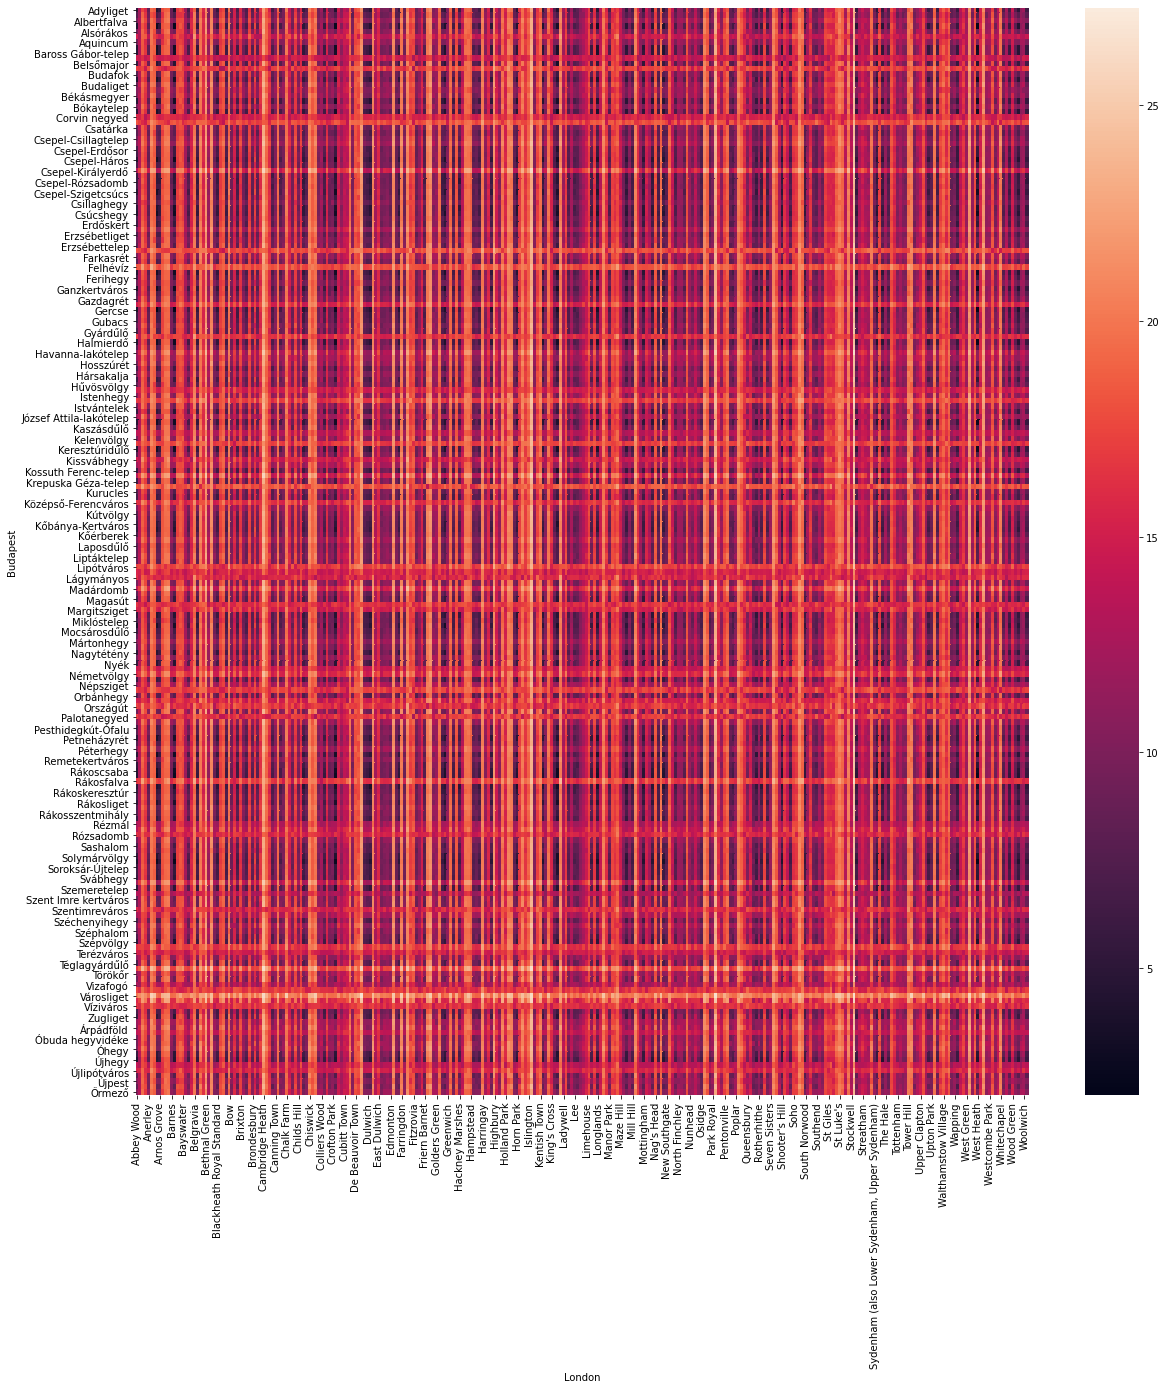

In [87]:
plt.figure(figsize=(20,20))
ax=sns.heatmap(df_distance_bp_london)
ax.set_xlabel('London')
ax.set_ylabel('Budapest')

Let's visalize data on map. First, I'm creating color shades, so similarity will be color coded. This code creates list of hex color codes from white (`color_range[0]`) to red (`color_range[99]`):

In [88]:
color_range=[]
hue=0
saturation=1
light=np.linspace(1,0.5,100)
for l in light:
    r,g,b=colorsys.hls_to_rgb(hue,l,saturation)
    color_range.append('#{0:02x}{1:02x}{2:02x}'.format(int(r*255),int(g*255),int(b*255)))


It's no point in putting all data to one map. Let's take my neighbourhood "Budafok" as an example and visualization similarities in London.

In [89]:
origin='Budafok'
target=df_distance_bp_london.loc[origin].transpose().reset_index()
df_london_similarity=df_london_freq[['Neighbourhood','Lat','Lon']].merge(target)
df_london_similarity

,Neighbourhood,Lat,Lon,Budafok
0,Abbey Wood,51.492612,0.118818,7.832645
1,Acton,51.508372,-0.274440,13.268170
2,Aldgate,51.513438,-0.077171,18.981974
3,Aldwych,51.513266,-0.117183,16.996274
4,Anerley,51.411911,-0.067978,9.738446
...,...,...,...,...
305,Woodford,51.604175,0.032502,9.930877
306,Woodford Green,51.609255,0.040552,7.978303
307,Woodside Park,51.616235,-0.187434,11.857543
308,Woolwich,51.489475,0.067588,12.213408


In [149]:
df_london_similarity['Budafok'].max()

24.29928651215916

For a correct visualization the data have to be normalized. First, I want a similarity index (i.e. the higher the amount the more similar), and for color coding they have to be within 0-99 range. I add it in a new column 'similarity'

In [186]:
minimum=np.amin(df_distance_bp_london.to_numpy())
maximum=np.amax(df_distance_bp_london.to_numpy())

df_london_similarity['similarity']=(df_london_similarity[origin]*-1+maximum)* \
                                    (99/(maximum-minimum))
df_london_similarity

,Neighbourhood,Lat,Lon,Budafok,similarity
0,Abbey Wood,51.492612,0.118818,7.832645,76.343775
1,Acton,51.508372,-0.274440,13.268170,54.987800
2,Aldgate,51.513438,-0.077171,18.981974,32.538476
3,Aldwych,51.513266,-0.117183,16.996274,40.340217
4,Anerley,51.411911,-0.067978,9.738446,68.855954
...,...,...,...,...,...
305,Woodford,51.604175,0.032502,9.930877,68.099897
306,Woodford Green,51.609255,0.040552,7.978303,75.771487
307,Woodside Park,51.616235,-0.187434,11.857543,60.530100
308,Woolwich,51.489475,0.067588,12.213408,59.131921


And now it can be visualized with folium library. The darker red a dot is the more similar to the neighbourhood in Budapest.

Please note that Github cannot show folium maps, but you can open this notebook in [nbviewer]().

In [232]:
title_html = '<h3 align="center" style="font-size:16px"><b>{} neighbourhood similarity index</b></h3>'.format(origin)
map=folium.Map(location=[51.51,-0.11],zoom_start=11)
for lat, lng, neighborhood, similarity in zip(df_london_similarity['Lat'], df_london_similarity['Lon'], 
                                            df_london_similarity['Neighbourhood'],df_london_similarity['similarity']):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        tooltip='{}, {:.0f}'.format(neighborhood, similarity),
        color=None,
        fill=True,
        fill_color=color_range[int(similarity)],
        fill_opacity=0.7,
        parse_html=False).add_to(map)  
    
map.get_root().html.add_child(folium.Element(title_html))
map

It seems the method works, so I'm creating a function to speed up creating maps with different setups. `similarity_map` does exactly the same as what I did in the previous four cells.

In [223]:
def similarity_map(df_pairwise,df_target_coords,origin_name,start_coords=[51.51,-.11],zoom_start=11):
    #creating a red color range:
    color_range=[]
    hue=np.linspace(0.2,1,100)
    saturation=1.0
    light=0.5
    for h in hue:
        r,g,b=colorsys.hls_to_rgb(h,light,saturation)
        color_range.append('#{0:02x}{1:02x}{2:02x}'.format(int(r*255),int(g*255),int(b*255)))
    
    #selecting and normalizing similarity index:
    target=df_pairwise.loc[origin_name].transpose().reset_index()
    minimum=np.amin(df_pairwise.to_numpy())
    maximum=np.amax(df_pairwise.to_numpy())
    df_similarity=df_target_coords[['Neighbourhood','Lat','Lon']].merge(target)
    df_similarity['similarity']=(df_similarity[origin_name]*-1+maximum)*(99/(maximum-minimum))
    
    #creating map:
    title_html = '<h3 align="center" style="font-size:16px"><b>{} neighbourhood similarity index</b></h3>'.format(origin_name)
    map=folium.Map(location=start_coords,zoom_start=zoom_start)
    for lat, lng, neighborhood, similarity in zip(df_similarity['Lat'], df_similarity['Lon'], 
                                            df_similarity['Neighbourhood'],df_similarity['similarity']):
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            tooltip='{}, {:.0f}'.format(neighborhood, similarity),
            color=None,
            fill=True,
            fill_color=color_range[int(similarity)],
            fill_opacity=0.7,
            parse_html=False).add_to(map)  
    
    map.get_root().html.add_child(folium.Element(title_html))
    return map

Let's try with some other neighbourhoods:

In [224]:
map=similarity_map(df_distance_bp_london,df_london_freq,'Terézváros')
map

In [225]:
map=similarity_map(df_distance_bp_london,df_london_freq,'Újpest')
map

The method just work nicely, the results are reasonable. Budafok is a suburb district in Budapest, Terézváros is part of the inner city while Újpest is somewhere in between. The similarity indices correspond with these.

Let's have a look at the same with other cities:

### Budapest vs. New York

In [193]:
X_newyork=df_newyork_freq[[x for x in df_newyork_freq.columns if x not in columns_exclude]]
common_columns=set(X_newyork.columns).intersection(df_bp_freq.columns)
X_newyork=X_newyork[common_columns]
X_bp=df_bp_freq[common_columns]

In [194]:
print('Common columns: ',len(common_columns))
print('New York shape: ',X_newyork.shape)
print('Budapest shape: ',X_bp.shape)

Common columns:  314
New York shape:  (306, 314)
Budapest shape:  (203, 314)


In [195]:
distance_matrix=pairwise_distances(X_bp,X_newyork)
distance_matrix

array([[12.03915799, 14.66019526, 10.87402065, ...,  5.96199002,
        18.72766203,  6.60827701],
       [11.68693822, 14.57654023, 10.379717  , ...,  4.77697865,
        18.44970257,  6.09340012],
       [11.86250079, 14.78201356, 10.94161437, ...,  4.98557168,
        18.34447941,  6.09638622],
       ...,
       [11.60774741, 14.64729668, 10.3807177 , ...,  4.34319007,
        18.23598914,  5.58509624],
       [12.70566409, 15.47085647, 11.4297594 , ...,  6.30407805,
        18.90130683,  6.63652017],
       [11.68469619, 14.70952498, 10.46953318, ...,  4.55742526,
        18.44836375,  5.57244336]])

In [196]:
distance_matrix.shape

(203, 306)

The function created a matrix that compares every neighbourhoods in Budapest with London. I'll convert back it into a DataFrame:

In [197]:
df_distance_bp_newyork=pd.DataFrame(distance_matrix,index=df_bp_freq['Neighbourhood'],columns=df_newyork_freq['Neighbourhood'])
df_distance_bp_newyork=df_distance_bp_newyork.sort_index(axis=0).sort_index(axis=1)
df_distance_bp_newyork

Neighbourhood,Allerton,Annadale,Arden Heights,Arlington,Arrochar,Arverne,Astoria,Astoria Heights,Auburndale,Bath Beach,...,Williamsbridge,Williamsburg,Willowbrook,Windsor Terrace,Wingate,Woodhaven,Woodlawn,Woodrow,Woodside,Yorkville
Neighbourhood,,,,,,,,,,,,,,,,,,,,,
Adyliget,12.996801,4.378793,4.966269,6.769182,5.848404,7.486242,16.788413,13.084717,17.901699,16.278600,...,11.479191,17.647233,8.847419,16.391883,14.571679,12.190522,10.977833,5.649586,18.714348,16.243486
Akadémiaújtelep,12.987988,7.816318,7.253470,8.232486,7.882691,9.270643,16.661147,13.751612,18.007938,16.332906,...,11.556160,18.251899,9.907968,17.219925,14.146053,12.425934,10.598671,7.338517,18.055078,16.419313
Albertfalva,14.796602,10.191880,10.073154,9.931235,9.428278,10.515342,17.712183,14.957621,18.992773,18.467578,...,13.850214,19.209566,11.783014,18.464166,15.507109,13.297046,13.295692,9.730438,19.293145,18.047754
Almáskert,13.373187,5.211442,5.162279,6.309447,5.673017,7.348410,16.845537,13.533999,17.956339,16.641218,...,12.235405,17.756974,8.958132,16.812112,14.706703,12.591828,11.156259,5.088529,18.712673,16.241063
Alsórákos,14.544652,9.934833,9.507203,10.176021,9.477283,10.839045,16.741532,14.163930,18.420991,16.721211,...,13.505588,18.805715,10.937500,16.237777,14.864485,13.906074,12.783540,8.693526,18.186338,16.008713
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Újlipótváros,17.596218,15.407625,14.604619,15.823603,15.319755,15.496480,17.324229,16.348422,20.630000,17.821697,...,16.983960,17.815131,16.619293,15.687269,18.246449,17.423114,16.419833,14.845282,19.815370,14.287369
Újpalota,14.479285,8.173231,7.643147,7.975036,7.606425,9.026611,16.505869,13.588146,18.855124,17.022564,...,13.135513,18.377424,9.985975,16.846044,14.939602,13.766615,12.710378,7.320191,17.859107,15.825413
Újpest,14.104538,10.607733,10.015388,9.770184,10.183320,10.919615,16.539649,14.155140,18.943812,17.291154,...,13.703868,18.297814,11.720239,16.710969,15.177417,13.959083,13.074020,10.071966,18.441258,16.172817


In [198]:
print('Average distance: ',np.array(df_distance_bp_newyork).mean(axis=None))
print('Std deviation: ',np.array(df_distance_bp_newyork).std(axis=None))

Average distance:  14.615261315921604
Std deviation:  4.727524595767043


It can be visualized on a heatmap. Please note that *distance* is calculated, so the smaller the amount is the more similar two neighbourhoods are.

Text(157.0, 0.5, 'Budapest')

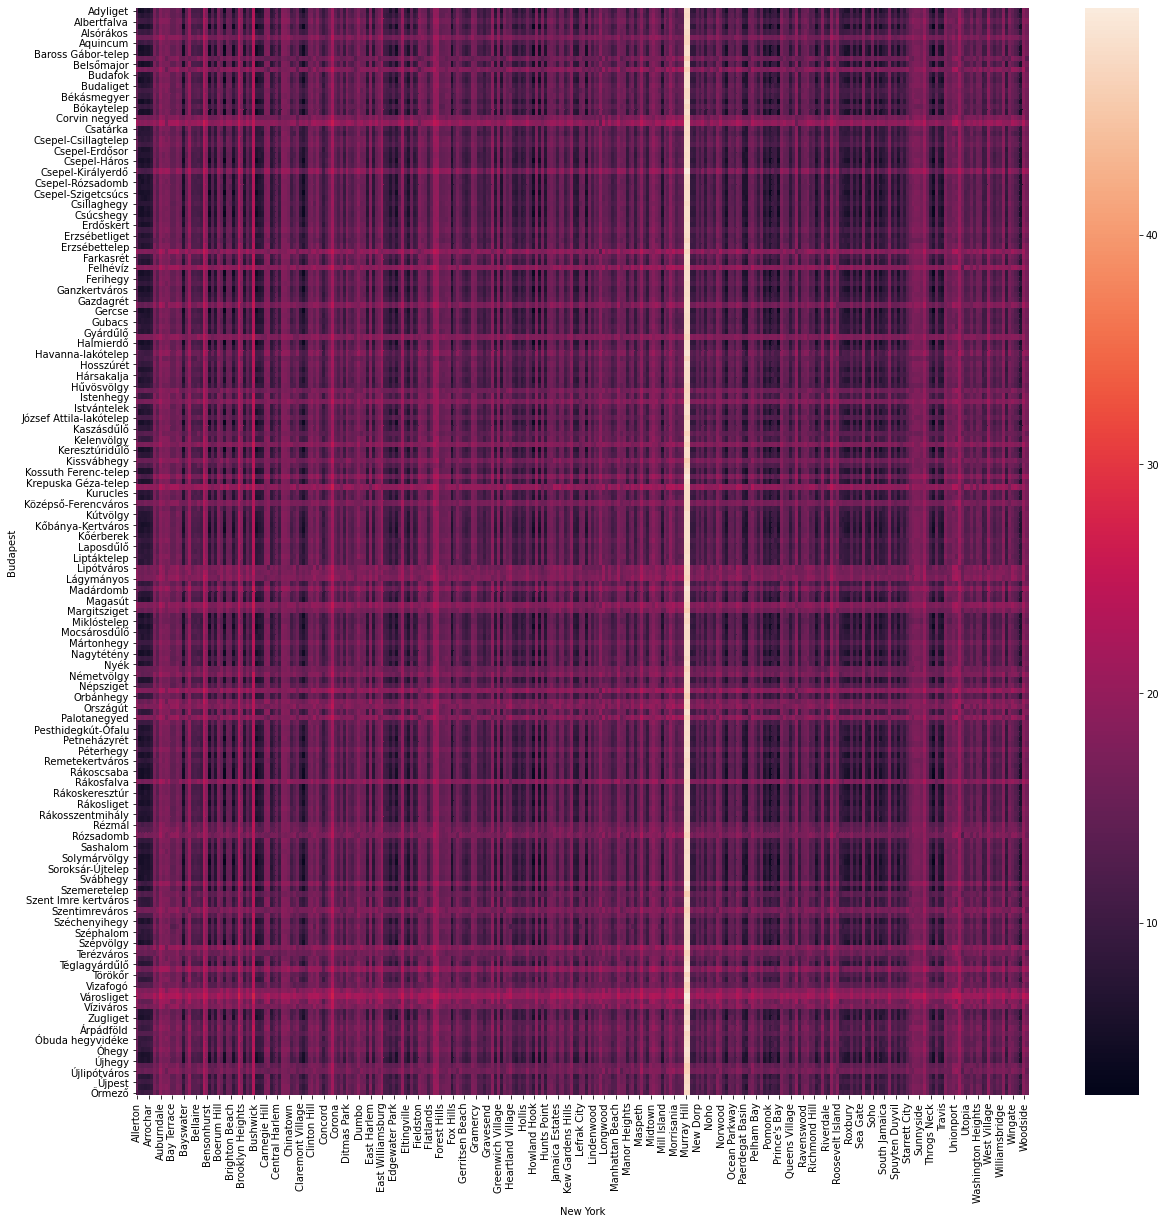

In [199]:
plt.figure(figsize=(20,20))
ax=sns.heatmap(df_distance_bp_newyork)
ax.set_xlabel('New York')
ax.set_ylabel('Budapest')

In [226]:
map=similarity_map(df_distance_bp_newyork,df_newyork_freq,'Budafok',start_coords=[40.7,-74],zoom_start=11)
map

In [227]:
map=similarity_map(df_distance_bp_newyork,df_newyork_freq,'Terézváros',start_coords=[40.7,-74],zoom_start=11)
map

In [228]:
map=similarity_map(df_distance_bp_newyork,df_newyork_freq,'Újpest',start_coords=[40.7,-74],zoom_start=11)
map

### Budapest vs. Toronto

In [203]:
X_toronto=df_toronto_freq[[x for x in df_toronto_freq.columns if x not in columns_exclude]]
common_columns=set(X_toronto.columns).intersection(df_bp_freq.columns)
X_toronto=X_toronto[common_columns]
X_bp=df_bp_freq[common_columns]

In [204]:
print('Common columns: ',len(common_columns))
print('Toronto shape: ',X_toronto.shape)
print('Budapest shape: ',X_bp.shape)

Common columns:  257
Toronto shape:  (94, 257)
Budapest shape:  (203, 257)


In [205]:
distance_matrix=pairwise_distances(X_bp,X_toronto)
distance_matrix

array([[ 6.05543764,  7.23258771, 18.76494937, ..., 17.21061664,
         7.49195068, 11.14016719],
       [ 5.66793834,  6.29980357, 19.01924092, ..., 17.13891843,
         6.43929538, 11.1072285 ],
       [ 4.9073338 ,  6.30094636, 18.4340968 , ..., 16.54656838,
         6.12036968, 10.16764107],
       ...,
       [ 5.20785945,  5.89336916, 18.89034939, ..., 16.93545984,
         6.04018212, 10.78868852],
       [ 6.0031575 ,  7.84996178, 19.43145388, ..., 17.59454177,
         8.08664949, 11.80219895],
       [ 4.79448902,  6.05120856, 18.88518268, ..., 17.04787743,
         6.19516949, 10.96841488]])

In [206]:
distance_matrix.shape

(203, 94)

The function created a matrix that compares every neighbourhoods in Budapest with London. I'll convert back it into a DataFrame:

In [207]:
df_distance_bp_toronto=pd.DataFrame(distance_matrix,index=df_bp_freq['Neighbourhood'],columns=df_toronto_freq['Neighbourhood'])
df_distance_bp_toronto=df_distance_bp_toronto.sort_index(axis=0).sort_index(axis=1)
df_distance_bp_toronto

Neighbourhood,Agincourt,"Alderwood, Long Branch","Bathurst Manor, Wilson Heights, Downsview North",Bayview Village,"Bedford Park, Lawrence Manor East",Berczy Park,"Birch Cliff, Cliffside West","Brockton, Parkdale Village, Exhibition Place","CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",Caledonia-Fairbanks,...,Westmount,Weston,"Wexford, Maryvale","Willowdale, Newtonbrook","Willowdale, Willowdale East","Willowdale, Willowdale West",Woburn,Woodbine Heights,York Mills West,"York Mills, Silver Hills"
Neighbourhood,,,,,,,,,,,,,,,,,,,,,
Adyliget,9.419545,7.041933,6.389665,8.094370,7.906948,18.950747,4.776487,16.038355,15.607845,6.985759,...,5.402113,5.710063,7.614711,12.897512,18.144884,5.746027,5.294226,9.151056,7.524216,5.496256
Akadémiaújtelep,10.981613,8.688373,8.642732,9.968793,9.184978,20.022833,8.167792,16.523765,16.834008,8.404512,...,8.062619,7.902394,8.934698,14.005814,18.357991,7.674296,7.866055,10.466271,10.320747,8.255654
Albertfalva,12.131588,10.305505,10.548385,11.488099,11.174588,20.475874,10.268808,17.420862,17.711336,10.826607,...,9.875496,9.646109,10.218827,14.918928,18.743944,9.562553,9.716709,11.574732,12.049623,9.641962
Almáskert,9.471596,7.386753,6.767210,8.513526,8.215055,19.597758,4.877717,16.436974,16.264628,7.467806,...,5.304727,5.618018,7.413172,12.934416,18.659425,5.655805,5.195395,9.310592,8.098958,5.019973
Alsórákos,11.085639,10.197887,10.441690,11.299442,10.888499,20.416143,9.859888,18.085337,17.357387,10.431150,...,9.855298,9.730719,10.297810,14.772573,18.354915,9.341381,10.004969,10.842366,11.620129,10.044645
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Újlipótváros,16.200630,14.059691,13.946645,13.307457,14.492081,17.260327,14.794607,15.947928,14.710095,14.907008,...,14.781370,14.699010,15.795091,15.796800,18.546938,14.314063,14.544910,13.594002,13.516967,14.242503
Újpalota,11.317562,9.647678,9.388914,10.333402,10.281984,19.747752,7.893491,17.034999,16.382970,9.379003,...,8.382106,8.589744,9.444983,13.833933,19.027551,8.269414,8.439739,10.615069,10.006758,7.997731
Újpest,13.137827,11.035307,11.519635,10.738552,11.670240,19.602296,10.440139,16.018505,17.224924,11.243932,...,10.709995,10.596981,11.210977,14.892011,18.716837,10.723269,10.379523,11.272001,12.033890,10.808700


In [208]:
print('Average distance: ',np.array(df_distance_bp_toronto).mean(axis=None))
print('Std deviation: ',np.array(df_distance_bp_toronto).std(axis=None))

Average distance:  12.869575524858977
Std deviation:  4.3458009356410825


It can be visualized on a heatmap. Please note that *distance* is calculated, so the smaller the amount is the more similar two neighbourhoods are.

Text(157.0, 0.5, 'Budapest')

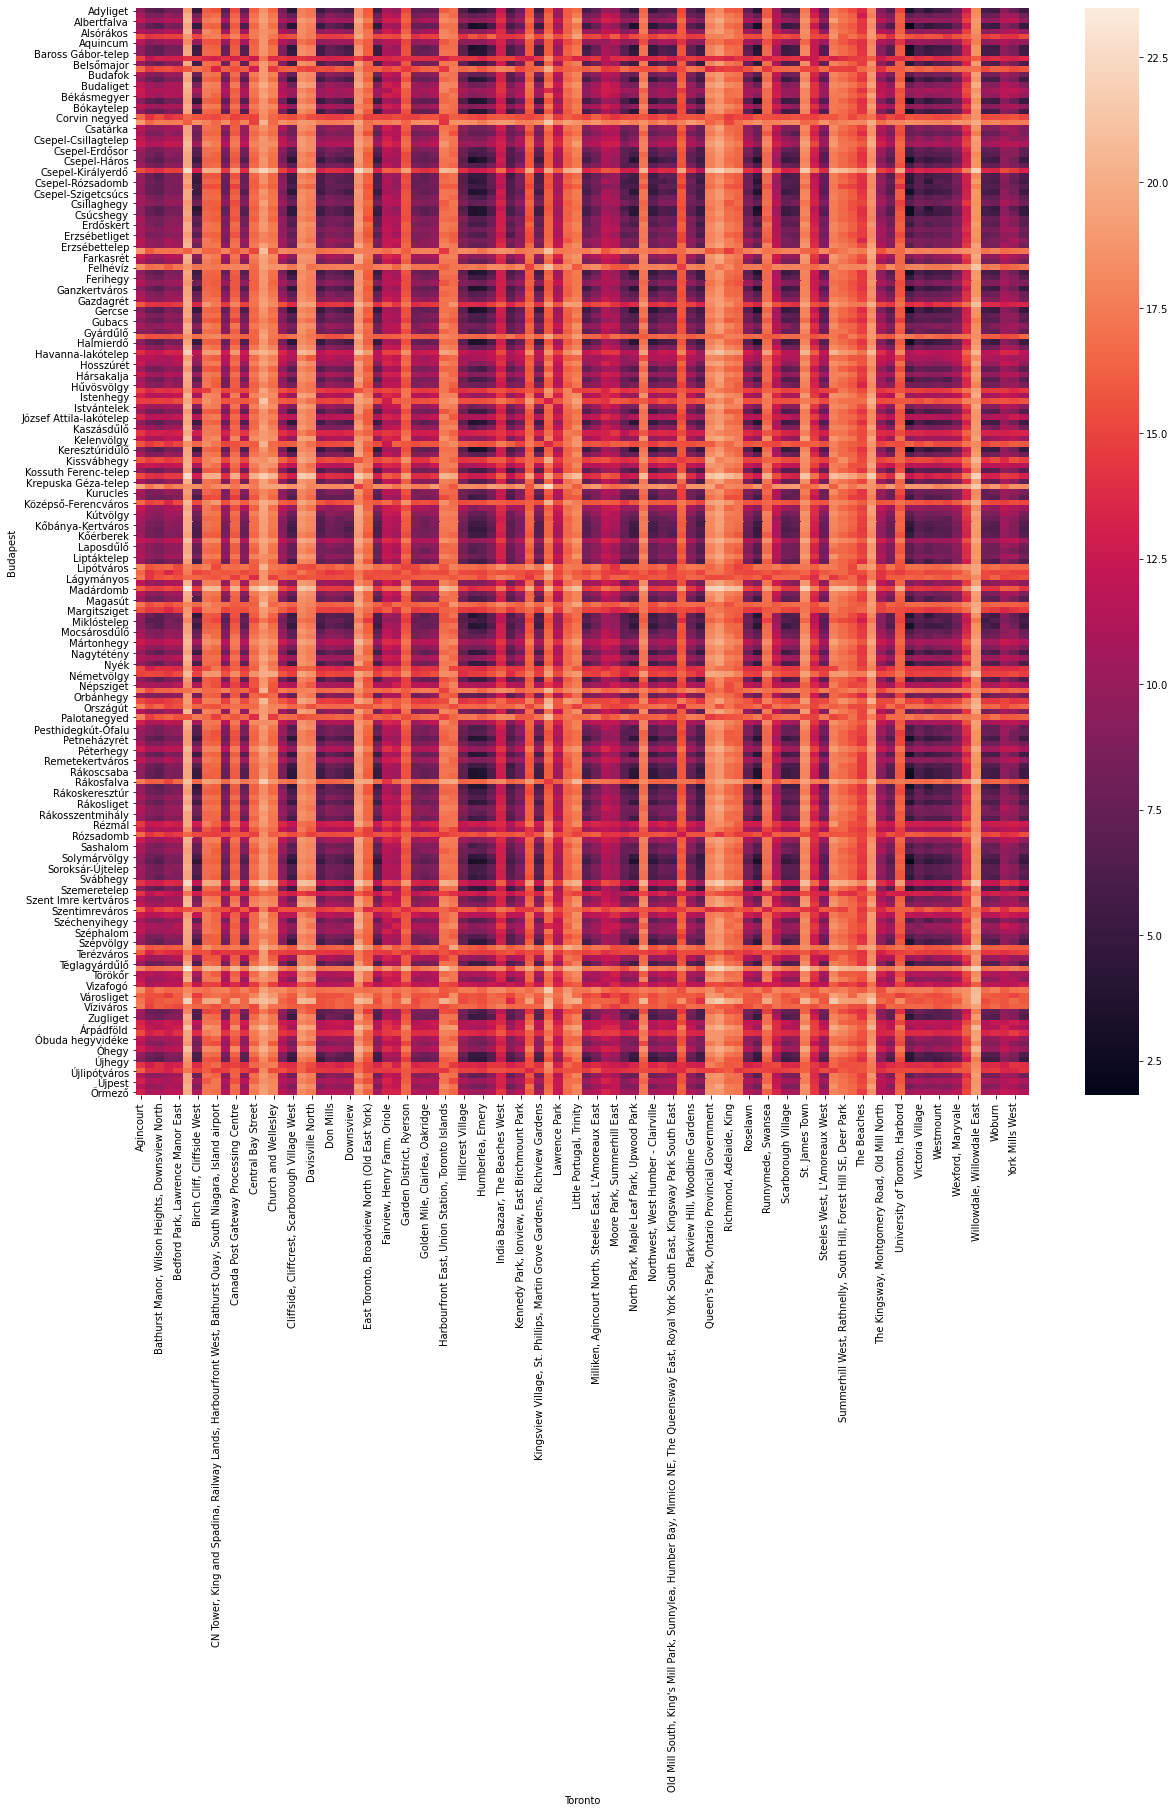

In [209]:
plt.figure(figsize=(20,20))
ax=sns.heatmap(df_distance_bp_toronto)
ax.set_xlabel('Toronto')
ax.set_ylabel('Budapest')

In [229]:
map=similarity_map(df_distance_bp_toronto,df_toronto_freq,'Budafok',start_coords=[43.7,-79.38],zoom_start=11)
map

In [230]:
map=similarity_map(df_distance_bp_toronto,df_toronto_freq,'Terézváros',start_coords=[43.7,-79.38],zoom_start=11)
map

In [231]:
map=similarity_map(df_distance_bp_toronto,df_toronto_freq,'Újpest',start_coords=[43.7,-79.38],zoom_start=11)
map